0) Librairies and "Plot" Function

In [59]:
from openturns.usecases import ishigami_function
import openturns as ot
from operator import itemgetter

import pylab as plt
import openturns.viewer
import openturns.viewer as viewer

import pandas as pd

from matplotlib import pylab as plt


In [60]:
def plotXvsY(sampleX, sampleY, figsize=(15, 3)):

    dimX = sampleX.getDimension()
    inputdescr = sampleX.getDescription()
    fig = plt.figure(figsize=figsize)

    for i in range(dimX):
        ax = fig.add_subplot(1, dimX, i + 1)
        graph = ot.Graph("", inputdescr[i], "Y", True, "")
        cloud = ot.Cloud(sampleX[:, i], sampleY)
        graph.add(cloud)
        _ = ot.viewer.View(graph, figure=fig, axes=[ax])

    return (fig)

In [61]:
def plotHist(sampleX, sampleY, figsize = (15, 3)):
    
    dimX = sampleX.getDimension() 
    dimY = sampleY.getDimension()
    dim = dimX + dimY
    inputdescrX = sampleX.getDescription()
    inputdescrY = sampleY.getDescription()
    fig = plt.figure(figsize = figsize)
    
    for i in range(dim):
        if i < dimX:
            ax = fig.add_subplot(1, dim, i + 1)
            graph = ot.Graph("", inputdescrX[i], "", True, "")
            hist = ot.HistogramFactory().build(sampleX[:, i]).drawPDF()
            graph.add(hist)
            _ = ot.viewer.View(graph, figure=fig, axes=[ax])
        else :
            ax = fig.add_subplot(1, dim, i + 1)
            graph = ot.Graph("", inputdescrY[dimX - i], "", True, "")
            hist = ot.HistogramFactory().build(sampleY[:, dimX - i]).drawPDF()
            graph.add(hist)
            _ = ot.viewer.View(graph, figure=fig, axes=[ax])
    
    return(fig)

1. Models and Input

A. Fluage (Eurocode)

In [62]:
##### INPUT #####

dim_fluage = 4
n_output = 1
input_fluage = ["uRh", "bfcm", "bt0", "t"]

mean_uRH, mean_bfcm, mean_bt0 = 0.451869, 2.7619, 0.48845
std_uRH, std_bfcm, std_bt0 = 0.15, 0.7, 0.15

X_eurocode = [ot.Normal(mean_uRH, std_uRH), 
     ot.Normal(mean_bfcm, std_bfcm), 
     ot.Normal(mean_bt0, std_bt0), 
     ot.Uniform(0, 200)]

distribution_fluage = ot.ComposedDistribution(X_eurocode)
distribution_fluage.setDescription(input_fluage)

##### PYTHON FUNCTION #####

def fluage_eurocode_formula(x):
    y = x[0] * x[1] * x[2] * ((x[3] - 28)/(477.90 + x[3] - 28))
    return [y]

model_fluage = ot.PythonFunction(dim_fluage, n_output, fluage_eurocode_formula)

##### FREEZE PARAMETERS #####

freez_indexes = []

##### PARAMETRIC PARAMETERS #####

if len(freez_indexes) > 0 :
    complement_fluage = ot.Indices(freez_indexes).complement(dim_fluage)
    
    model_fluage = ot.ParametricFunction(
        model_fluage, freez_indexes, distribution_fluage.getMarginal(freez_indexes).getMean()
    )

    distribution_fluage = distribution_fluage.getMarginal(complement_fluage)
    input_fluage_copy = list(input_fluage)
    input_fluage = itemgetter(*complement_fluage)(input_fluage)
    dim_fluage = len(complement_fluage)

B. Borehole WaterFlow

In [63]:
##### INPUT ##### 

dim_aquifer = 8
input_aquifer = ["rw", "r", "Tu", "Hu", "Tl", "Hl", "L", "Kw"]

X_aquifer = [
    ot.Normal(0.1, 0.0161812),
    ot.LogNormal(7.71, 1.0056),
    ot.Uniform(63070.0, 115600.0),
    ot.Uniform(990.0, 1110.0),
    ot.Uniform(63.1, 116.0),
    ot.Uniform(700.0, 820.0),
    ot.Uniform(1120.0, 1680.0),
    ot.Uniform(9855.0, 12045.0),
]

distribution_aquifer = ot.ComposedDistribution(X_aquifer)
distribution_aquifer.setDescription(input_aquifer)

##### ANALYTICAL MODEL #####

model_aquifer = ot.SymbolicFunction(
    input_aquifer, [
        "(2*pi_*Tu*(Hu-Hl))/(ln(r/rw)*(1+(2*L*Tu)/(ln(r/rw)*rw^2*Kw)+Tu/Tl))"]
)

##### FREEZE PARAMETERS #####

freez_indexes = [0]

if len(freez_indexes) > 0 :
    complement_aquifer = ot.Indices(freez_indexes).complement(dim_aquifer)

    model_aquifer = ot.ParametricFunction(
        model_aquifer, freez_indexes, distribution_aquifer.getMarginal(freez_indexes).getMean()
    )

    distribution_aquifer = distribution_aquifer.getMarginal(complement_aquifer)
    input_aquifer_copy = list(input_aquifer)
    input_aquifer = itemgetter(*complement_aquifer)(input_aquifer)
    dimension = len(complement_aquifer)


C. Select UseCase

In [64]:
fluage = True

if fluage : 
    model = model_fluage
    distribution = distribution_fluage
    dimension = dim_fluage
    input_names = input_fluage

else :
    model = model_aquifer
    distribution = distribution_aquifer
    dimension = dim_aquifer
    input_names = input_aquifer
    

2) Sobol’ sensitivity indices


We estimate the Sobol’ indices of a function by sampling methods. This function has several outputs, which leads to the need of aggregated Sobol’ indices.

A) Design of Experiment

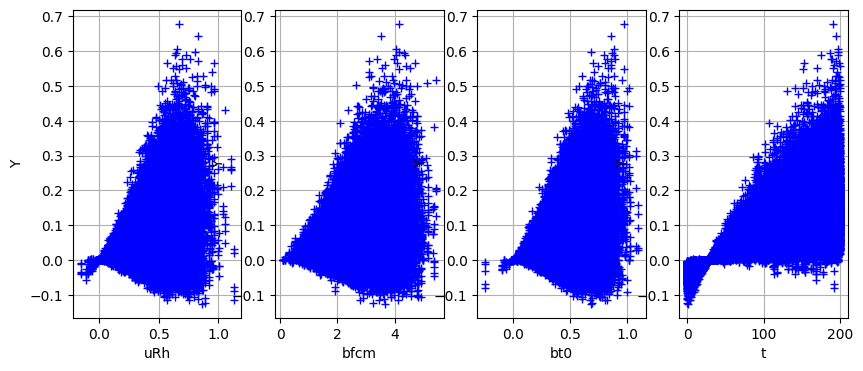

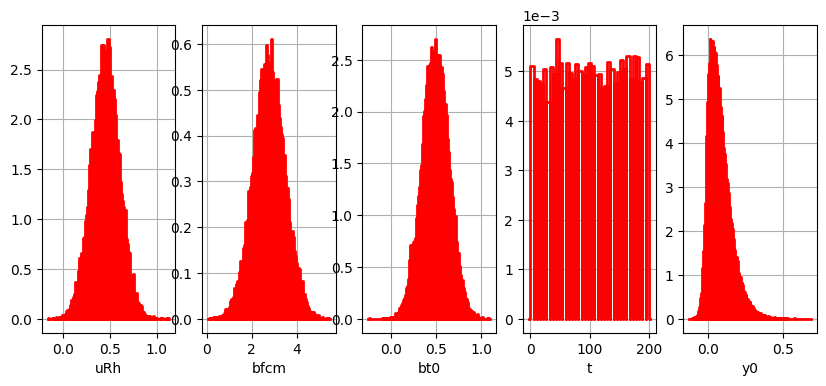

100000

In [65]:
# SOBOL SAMPLING

n = 10000
computeSecondOrder = True

sie = ot.SobolIndicesExperiment(distribution, n, computeSecondOrder)

sampleX = sie.generate()
sampleY = model(sampleX)

plotXvsY(sampleX, sampleY, figsize=(10, 4))
plt.show()

plotHist(sampleX, sampleY, figsize=(10, 4))
plt.show()

sampleX.getSize()


B) Analysis

In [66]:
# SOBOL SENSITIVITY ANALYSIS (First, Second and Total order)

print_result = True
plot_result = True

sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(sampleX, sampleY, n)
#sensitivityAnalysis = MartinezSensitivityAlgorithm(inputDesign, outputDesign, n)
#sensitivityAnalysis = JansenSensitivityAlgorithm(inputDesign, outputDesign, n)
#sensitivityAnalysis = MauntzKucherenkoSensitivityAlgorithm(inputDesign, outputDesign, n)

fo = sensitivityAnalysis.getFirstOrderIndices()
to = sensitivityAnalysis.getTotalOrderIndices()

if computeSecondOrder:
    so = sensitivityAnalysis.getSecondOrderIndices()

print_result = True
plot_result = True

if print_result:
    print('---------------------')
    print('First order indices :')
    print(fo)

    if computeSecondOrder:
        print()
        print('---------------------')
        for i in range(dimension):
            for j in range(i):
                print(
                    input_names[i] + " & " + input_names[j],
                    ":",
                    so[i, j],
                )
    print()
    print('---------------------')
    print('First order indices :')
    print(to)


---------------------
First order indices :
[0.0887763,0.0513738,0.0836574,0.550884]

---------------------
bfcm & uRh : 0.029768350369154678
bt0 & uRh : 0.035505289681359894
bt0 & bfcm : 0.0275270402761197
t & uRh : 0.07783823233699824
t & bfcm : 0.05410140364913055
t & bt0 : 0.04862148988608324

---------------------
First order indices :
[0.203643,0.119297,0.157803,0.730382]


If we observe that the total order indices closely resemble the first-order indices, it suggests that the higher-order indices are likely to be very close to 0. This implies that the interactions between variables have minimal or negligible effects on the result

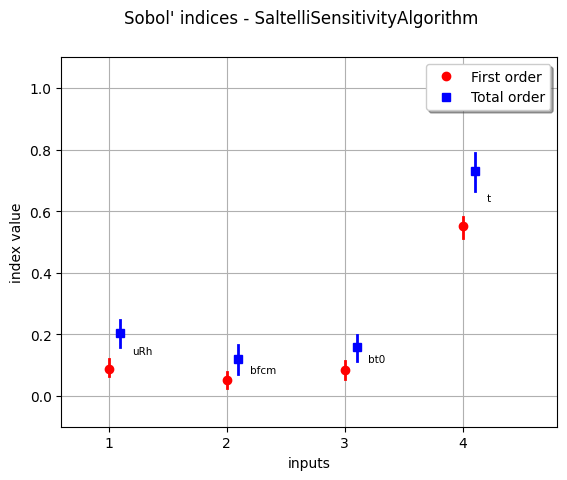

In [67]:
if plot_result:
    graph = sensitivityAnalysis.draw()
    view = viewer.View(graph)
    plt.show()

3) Sobol’ sensitivity indices from chaos


We are going to compute global sensitivity indices from a functional chaos decomposition.

A) Design of Experiment

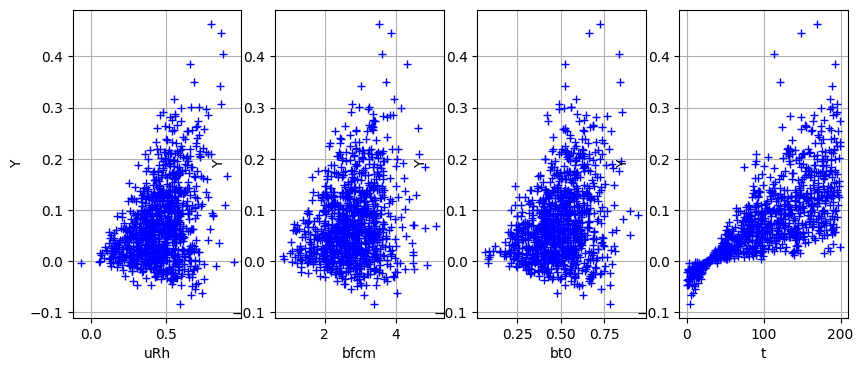

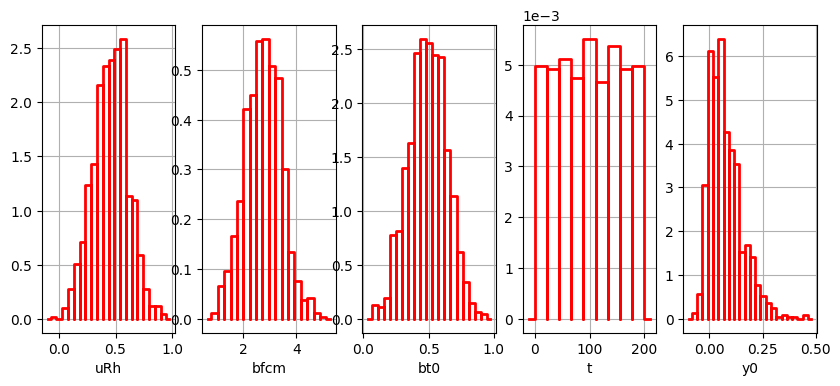

In [68]:
# MONTE CARLO BRUT FORCE

n = 1000

sampleX = distribution.getSample(n)
sampleY = model(sampleX)

plotXvsY(sampleX, sampleY, figsize=(10, 4))
plt.show()

plotHist(sampleX, sampleY, figsize=(10, 4))
plt.show()

B) Analysis

In [69]:
# SOBOL SENSITIVITY ANALYSIS FROM CHAOS (First, Second and Total order)

algo = ot.FunctionalChaosAlgorithm(sampleX, sampleY)
algo.run()
result = algo.getResult()

print(result.getResiduals())
print(result.getRelativeErrors())


[3.61316e-05]
[0.000220184]


In [70]:
sensitivityAnalysis = ot.FunctionalChaosSobolIndices(result)

fo = [sensitivityAnalysis.getSobolIndex(i) for i in range(dimension)]
to = [sensitivityAnalysis.getSobolTotalIndex(i) for i in range(dimension)]

print_result = True
plot_result = True

if print_result:
    print('---------------------')
    print('First order indices :')
    print(fo)

    if computeSecondOrder:
        print()
        print('---------------------')
        for i in range(dimension):
            for j in range(i):
                print(
                    input_names[i] + " & " + input_names[j],
                    ":",
                    sensitivityAnalysis.getSobolIndex([i, j]),
                )
    print()
    print('---------------------')
    print('First order indices :')
    print(to)


---------------------
First order indices :
[0.04298970772519307, 0.06928096143459955, 0.6185805844219667, 0.20399886122868705]

---------------------
bfcm & uRh : 0.0023986720474622374
bt0 & uRh : 0.0036339553157357014
bt0 & bfcm : 0.0016788855822432163
t & uRh : 0.023795434365245283
t & bfcm : 0.011737031519091794
t & bt0 : 0.017580909983792924

---------------------
First order indices :
[0.07621467067206693, 0.08749858680790781, 0.6444740554958647, 0.26128756858969715]


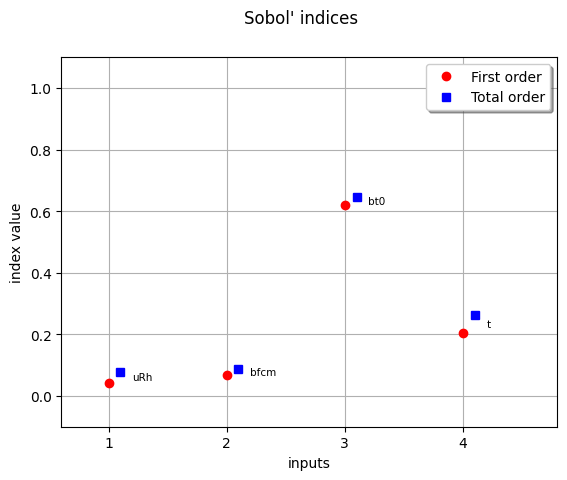

In [71]:
if plot_result:
    graph = ot.SobolIndicesAlgorithm.DrawSobolIndices(input_names, fo, to)
    view = viewer.View(graph)

4) Parallel coordinates graph as sensitivity tool


A) Design of Experiment

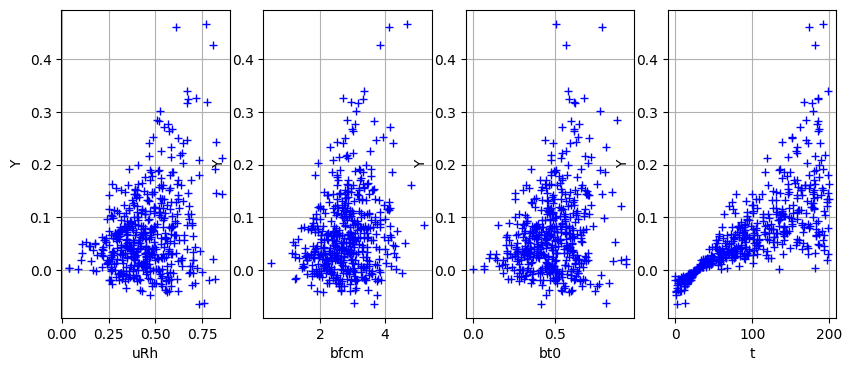

In [72]:
# MONTE CARLO BRUT FORCE

n = 500

sampleX = distribution.getSample(n)
sampleY = model(sampleX)

fig_test = plotXvsY(sampleX, sampleY, figsize=(10, 4))
plt.show()


B) Analysis

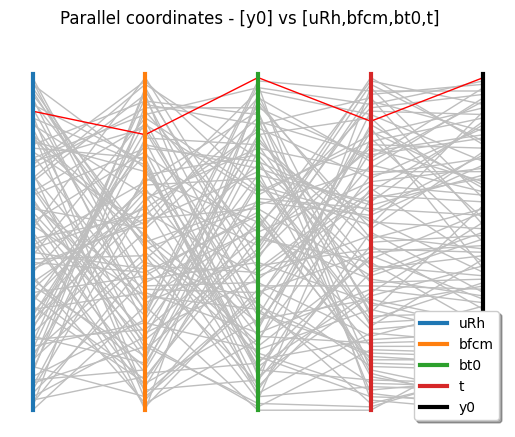

In [77]:
# OUTPUT SCALE
# Value based scale to describe the Y range

minValue = 0.35
maxValue = 0.4

quantileScale = False
graphCobweb = ot.VisualTest.DrawParallelCoordinates(
    sampleX, sampleY, minValue, maxValue, "red", quantileScale
)
graphCobweb.setLegendPosition("bottomright")
view = viewer.View(graphCobweb)


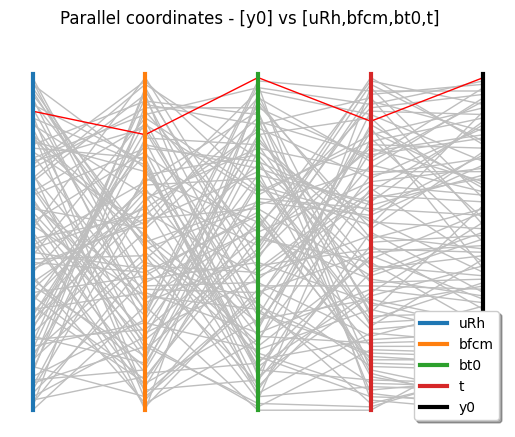

In [78]:
# QUANTILE SCALE
# Rank based scale to describe the Y range

minValue = 0.99
maxValue = 1.0
quantileScale = True
graphCobweb = ot.VisualTest.DrawParallelCoordinates(
    sampleX, sampleY, minValue, maxValue, "red", quantileScale
)
graphCobweb.setLegendPosition("bottomright")
view = viewer.View(graphCobweb)
plt.show()


4) The HSIC (Hilbert-Schmidt Indepencence Criterion) sensitivity indices

A) Design of Experiment

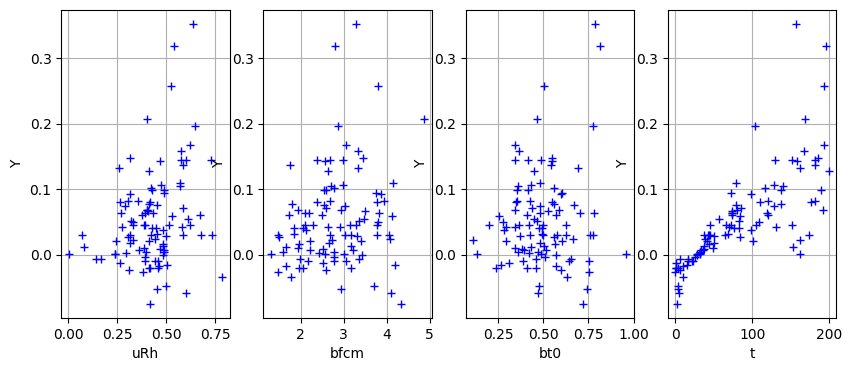

In [80]:
# MONTE CARLO BRUT FORCE

n = 100

sampleX = distribution.getSample(n)
sampleY = model(sampleX)

fig_test = plotXvsY(sampleX, sampleY, figsize=(10, 4))
plt.show()


B) Analysis

The HSIC algorithms use reproducing kernels defined on Hilbert spaces to estimate independence. For each input variable we choose a covariance kernel. Here we choose a SquaredExponential kernel for all input variables.

They are all stored in a list of d+1 covariance kernels where d is the number of input variables. The remaining one is for the output variable.

In [83]:
# Setting the covariance models

covarianceModelCollection = []

for i in range(dimension):
    Xi = sampleX.getMarginal(i)
    # Edit if this is not the good covariance function
    inputCovariance = ot.SquaredExponential(1)
    inputCovariance.setScale(Xi.computeStandardDeviation())
    covarianceModelCollection.append(inputCovariance)

# Likewise we define a covariance kernel associated to the output variable.

outputCovariance = ot.SquaredExponential(1)
outputCovariance.setScale(sampleY.computeStandardDeviation())
covarianceModelCollection.append(outputCovariance)


Global HSIC estimator

We perform the analysis on the raw data: that is the global HSIC estimator.
After having defined the covariance kernels one has to select an appropriate estimator for the computations.

Two estimators are proposed:

- an unbiased estimator through the HSICUStat class

- a biased, but asymptotically unbiased, estimator through the HSICVStat class

In [87]:
# unbiased estimator

estimatorType = ot.HSICUStat()

globHSIC = ot.HSICEstimatorGlobalSensitivity(
    covarianceModelCollection, sampleX, sampleY, estimatorType
)

R2HSICIndices = globHSIC.getR2HSICIndices()
print("\n Global HSIC analysis")
print("R2-HSIC Indices: ", R2HSICIndices)

HSICIndices = globHSIC.getHSICIndices()
print("HSIC Indices: ", HSICIndices)

pvperm = globHSIC.getPValuesPermutation()
print("p-value (permutation): ", pvperm)

pvas = globHSIC.getPValuesAsymptotic()
print("p-value (asymptotic): ", pvas)


 Global HSIC analysis
R2-HSIC Indices:  [0.0503859,0.0188742,0.00672865,0.579798]
HSIC Indices:  [0.00287433,0.00123731,0.000402582,0.0417403]
p-value (permutation):  [0,0.0594059,0.227723,0]
p-value (asymptotic):  [0.00732318,0.0828319,0.268493,1.01815e-16]


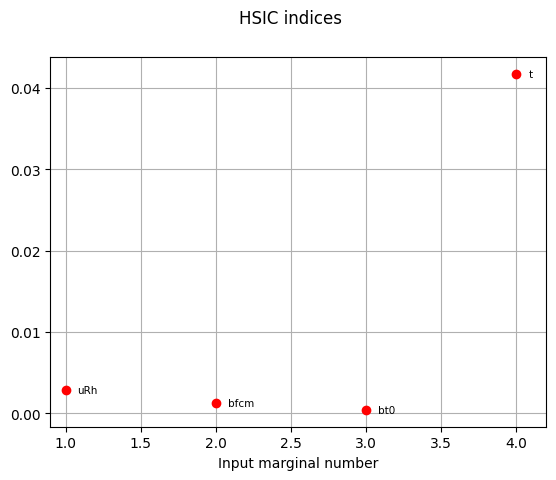

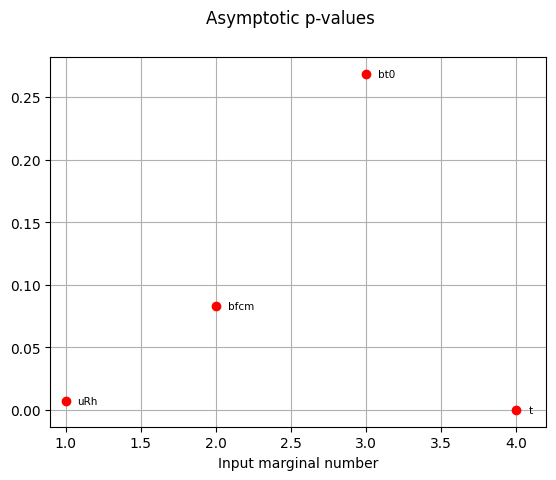

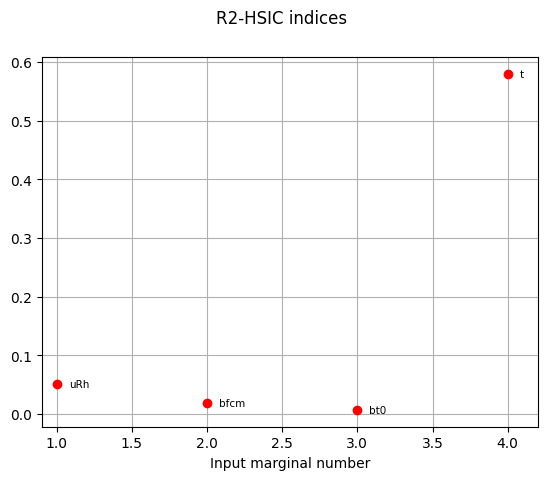

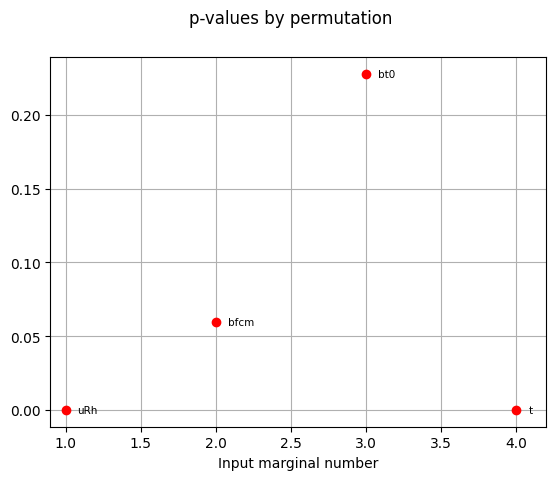

In [88]:
graph1 = globHSIC.drawHSICIndices()
view1 = viewer.View(graph1)

graph2 = globHSIC.drawPValuesAsymptotic()
view2 = viewer.View(graph2)

graph3 = globHSIC.drawR2HSICIndices()
view3 = viewer.View(graph3)

graph4 = globHSIC.drawPValuesPermutation()
view4 = viewer.View(graph4)

The Target HSIC estimator

We now perform the target analysis which consists in using a filter function over the output.

We define a filter function on the output variable for the target analysis. In this example we use the function exp(-d/s) where d is the distance to a well-chosen interval.

We present the methods on the Ishigami function (usecave module from Openturns)

In [100]:
im = ishigami_function.IshigamiModel()

size = 100
X = im.distributionX.getSample(size)
Y = im.model(X)

covarianceModelCollection = []

for i in range(3):
    Xi = X.getMarginal(i)
    inputCovariance = ot.SquaredExponential(1)
    inputCovariance.setScale(Xi.computeStandardDeviation())
    covarianceModelCollection.append(inputCovariance)

outputCovariance = ot.SquaredExponential(1)
outputCovariance.setScale(Y.computeStandardDeviation())
covarianceModelCollection.append(outputCovariance)
    

In [101]:
criticalDomain = ot.Interval(5, float("inf"))

dist2criticalDomain = ot.DistanceToDomainFunction(criticalDomain)

s = 0.1 * Y.computeStandardDeviation()[0]

f = ot.SymbolicFunction(["x", "s"], ["exp(-x/s)"])
phi = ot.ParametricFunction(f, [1], [s])
filterFunction = ot.ComposedFunction(phi, dist2criticalDomain)

In [102]:
estimatorType = ot.HSICUStat()

targetHSIC = ot.HSICEstimatorTargetSensitivity(
    covarianceModelCollection, X, Y, estimatorType, filterFunction
)

R2HSICIndices = targetHSIC.getR2HSICIndices()
print("\n Target HSIC analysis")
print("R2-HSIC Indices: ", R2HSICIndices)

HSICIndices = targetHSIC.getHSICIndices()
print("HSIC Indices: ", HSICIndices)

pvperm = targetHSIC.getPValuesPermutation()
print("p-value (permutation): ", pvperm)

pvas = targetHSIC.getPValuesAsymptotic()
print("p-value (asymptotic): ", pvas)


 Target HSIC analysis
R2-HSIC Indices:  [0.161734,0.0143782,-0.0102029]
HSIC Indices:  [0.000827408,6.96791e-05,-4.8837e-05]
p-value (permutation):  [0,0.148515,0.752475]
p-value (asymptotic):  [3.24769e-06,0.132816,0.775436]


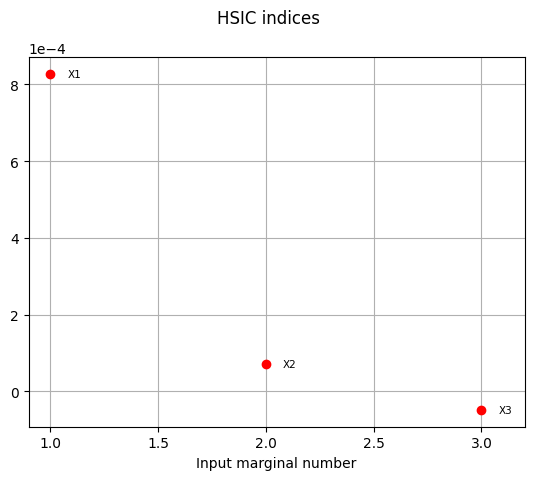

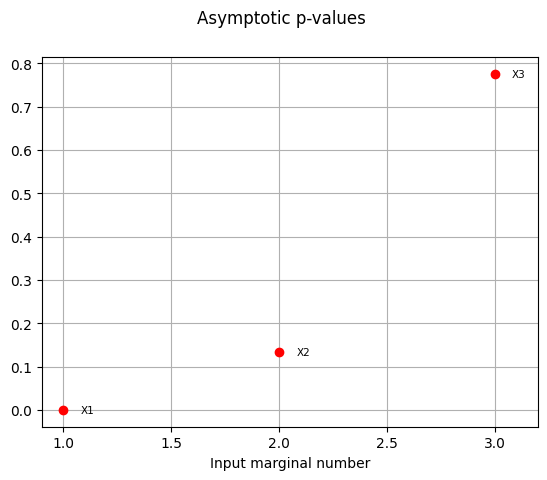

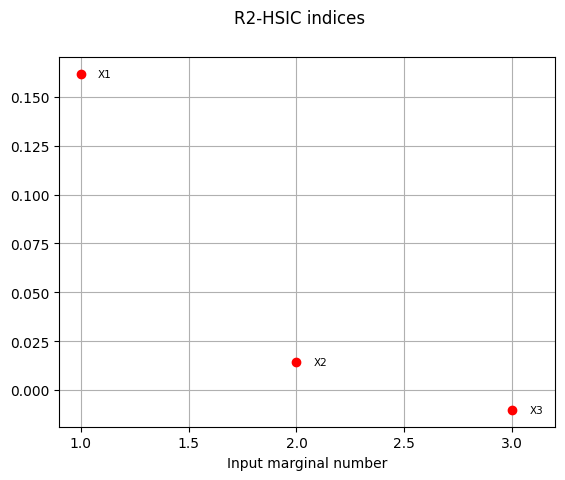

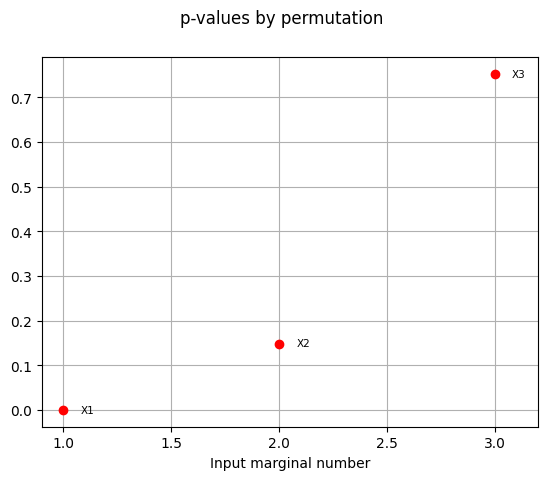

In [103]:
graph5 = targetHSIC.drawHSICIndices()
view5 = viewer.View(graph5)

graph6 = targetHSIC.drawPValuesAsymptotic()
view6 = viewer.View(graph6)

graph7 = targetHSIC.drawR2HSICIndices()
view7 = viewer.View(graph7)

graph8 = targetHSIC.drawPValuesPermutation()
view8 = viewer.View(graph8)

The Conditional HSIC estimator

In this last section we preprocess the input variables: that is the conditional analysis. To do so, one has to work with a weight function. Here the weight function is the filter function we used previously.

We have to select a biased -but asymptotically unbiased- estimator
We build the conditional HSIC estimator

In [104]:
weightFunction = filterFunction

estimatorType = ot.HSICVStat()

condHSIC = ot.HSICEstimatorConditionalSensitivity(
    covarianceModelCollection, X, Y, weightFunction
)

R2HSICIndices = condHSIC.getR2HSICIndices()
print("\n Conditional HSIC analysis")
print("R2-HSIC Indices: ", R2HSICIndices)

HSICIndices = condHSIC.getHSICIndices()
print("HSIC Indices: ", HSICIndices)

pvperm = condHSIC.getPValuesPermutation()
print("p-value (permutation): ", pvperm)
print("")


 Conditional HSIC analysis
R2-HSIC Indices:  [0.231367,0.0266067,0.189697]
HSIC Indices:  [0.00876551,0.00118124,0.00704499]
p-value (permutation):  [0,0.584158,0.00990099]



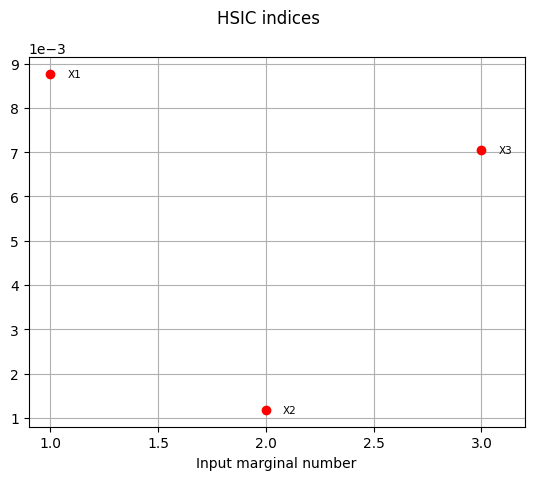

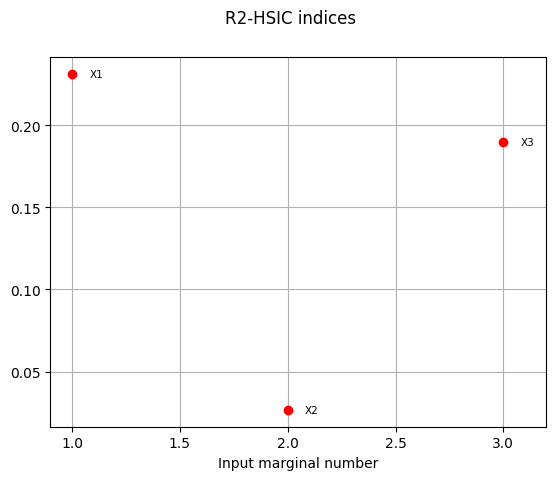

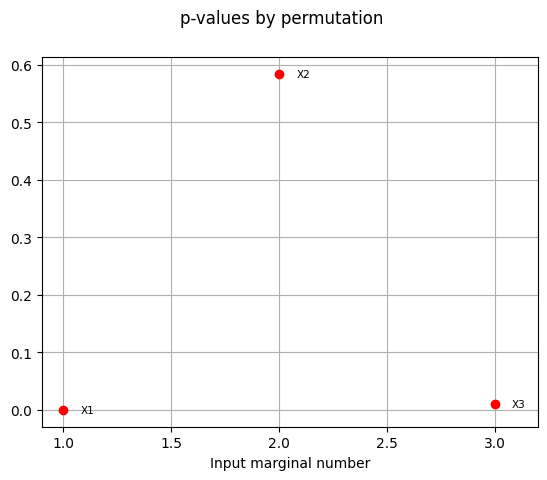

In [105]:
graph9 = condHSIC.drawHSICIndices()
view9 = viewer.View(graph9)

graph10 = condHSIC.drawR2HSICIndices()
view10 = viewer.View(graph10)

graph11 = condHSIC.drawPValuesPermutation()
view11 = viewer.View(graph11)